# Bootstrap ROIs with a separate baseline for ketamine and placebo

This script bootstraps the following differences:
* Ketamine-Baseline
* Placebo-Baseline
* (Ketamine-Baseline) - (Placebo-Baseline)

for distances of all voxels to their respective ROI centroid and creates density plots for each condition.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pickle
#from scipy import stats
from scipy import spatial
from scipy.spatial import distance
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import scipy.stats as st
import os

Input: List of distances to ROI centroids + ROI membership

In [11]:
b_k = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Ket/B_K_centroid', allow_pickle=True)
b_p = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Placebo/B_P_centroid', allow_pickle=True)
ket = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Ket/K_centroid',allow_pickle=True)
placebo = np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Placebo/P_centroid',allow_pickle=True)

In [12]:
placebo.iloc[14]

x       -2.66144
y       -3.63644
ROI         OFC2
ID        215532
Dist    0.512357
Name: 14, dtype: object

In [13]:
b_k

,x,y,ROI,ID,Dist
0,2.056997,-2.460254,OFC1,205886,0.744603
1,2.519534,-1.330369,OFC1,205887,1.103596
2,2.159429,-2.477863,OFC1,205978,0.827377
3,1.919475,-2.509093,OFC1,206069,0.705265
4,1.932751,-2.383243,OFC1,206160,0.606814
...,...,...,...,...,...
11878,-0.910370,4.515695,Caudate,491073,1.120259
11879,-0.873054,4.543928,Caudate,491164,1.156976
11880,-0.851213,4.525461,Caudate,491255,1.179112
11881,-0.863534,4.552104,Caudate,491346,1.166457


In [15]:
ket.iloc[14]

x             1.11276
y           -0.864093
ROI              OFC2
ID             215532
Dist          1.32684
Diff         0.120926
Diff_k_p    0.0742885
Name: 14, dtype: object

In [16]:
ket

,x,y,ROI,ID,Dist,Diff,Diff_k_p
0,1.133926,-0.809377,OFC1,205886,0.470489,-0.274115,0.110611
1,1.134167,-0.851568,OFC1,205887,0.479085,-0.624511,-0.383646
2,1.101762,-0.911788,OFC1,205978,0.466833,-0.360545,-0.564791
3,1.149000,-0.465464,OFC1,206069,0.551062,-0.154203,-0.524395
4,1.019709,-0.775353,OFC1,206160,0.352734,-0.254080,-0.322460
...,...,...,...,...,...,...,...
11878,-2.722308,4.898921,Caudate,491073,0.882184,-0.238075,-0.165976
11879,-2.703566,4.901717,Caudate,491164,0.900251,-0.256725,-0.174154
11880,-2.700493,4.900335,Caudate,491255,0.902417,-0.276694,-0.291244
11881,-2.707304,4.912504,Caudate,491346,0.901663,-0.264794,-0.242347


In [17]:
k=ket[['Dist', 'ROI']].values.tolist()

In [18]:
k

[[0.47048874716792083, 'OFC1'],
 [0.47908541530795606, 'OFC1'],
 [0.4668328292551204, 'OFC1'],
 [0.5510615960529489, 'OFC1'],
 [0.3527336187158164, 'OFC1'],
 [0.765313169397975, 'OFC2'],
 [0.7872875224176212, 'OFC2'],
 [0.7138280906859851, 'OFC2'],
 [1.4415944144576736, 'OFC2'],
 [1.3442246914585483, 'OFC2'],
 [0.6531982938951854, 'OFC2'],
 [1.4033010109555843, 'OFC2'],
 [0.6661474093440922, 'OFC2'],
 [0.09730442296355693, 'OFC1'],
 [1.3268442936541498, 'OFC2'],
 [1.4604152179864958, 'OFC2'],
 [1.6743111305430323, 'OFC2'],
 [1.4668514626983906, 'OFC2'],
 [0.4954582388444684, 'OFC1'],
 [0.48516483652478565, 'OFC1'],
 [0.34770093045040085, 'OFC1'],
 [0.47804401395826557, 'OFC1'],
 [0.3962314401154137, 'OFC1'],
 [0.588997283906997, 'OFC1'],
 [0.5965319812472535, 'OFC1'],
 [0.5021456723342469, 'OFC1'],
 [0.5522064800933709, 'OFC1'],
 [0.19878774628560497, 'OFC1'],
 [0.273435572225662, 'OFC1'],
 [0.4933769346399923, 'OFC1'],
 [0.5451507875965911, 'OFC1'],
 [0.6237440821140559, 'OFC1'],
 [0.

**Function:**

* Input baseline, ketamin and placebo distances of all voxels and ROI

* Output: dictionary for one ROI that contains the distance values for all conditions

In [19]:
def create_roi_dict(k, p, b_k, b_p, roi):
    
    k_dist = k[['Dist', 'ROI']].values.tolist()
    b_k_dist = b_k[['Dist', 'ROI']].values.tolist()
    p_dist = p[['Dist', 'ROI']].values.tolist()
    b_p_dist = b_p[['Dist', 'ROI']].values.tolist()
    
    k_list=[]
    p_list=[]
    b_k_list=[]
    b_p_list=[]
    
    roi_dict = {}
    # baseline, ketamine, placebo dictionaries
    for i in range(len(k_dist)):
        if k_dist[i][1]==roi:
            k_list.append(k_dist[i][0])    
        if p_dist[i][1]==roi:
            p_list.append(p_dist[i][0])
        if b_k_dist[i][1]==roi:
            b_k_list.append(b_k_dist[i][0])   
        if b_p_dist[i][1]==roi:
            b_p_list.append(b_p_dist[i][0])
    
    roi_dict = {'Ketamine': k_list,
               'Placebo': p_list,
               'Baseline_k': b_k_list,
               'Baseline_p': b_p_list}
    
    name='dist_all_cond_' + str(roi)
    # dictionary for the chosen ROI
    np.save(os.path.join('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/', name), roi_dict)
    return roi_dict

Bootstrapping of the mean of the conditions

In [20]:
def calculate_bootstrap(roi):
    
    # dictionary for the chosen ROI
    roi_dict = create_roi_dict(ket, placebo, b_k, b_p, roi)
    
    # get the distance values as a arrays: 3 different arrays for each condition
    b_k_arr = np.asarray(roi_dict['Baseline_k'])
    b_p_arr = np.asarray(roi_dict['Baseline_p'])
    k_arr = np.asarray(roi_dict['Ketamine'])
    p_arr = np.asarray(roi_dict['Placebo'])
    
    # Subtract baseline
    dist_k = k_arr - b_k_arr
    dist_p = p_arr - b_p_arr
    
    dist = dist_k - dist_p
    
    # Bootstrap
    bsr_k_b = bs.bootstrap(dist_k, stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
    bsr_p_b = bs.bootstrap(dist_p, stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
    bsr = bs.bootstrap(dist, stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
    
    # transfer to combined dataframe
    bsr_k_b_df = pd.DataFrame(bsr_k_b)
    bsr_p_b_df = pd.DataFrame(bsr_p_b)
    bsr_df = pd.DataFrame(bsr)
    bsr_com= pd.concat([bsr_k_b_df, bsr_p_b_df, bsr_df], axis=1)
    bsr_com.columns = ['Ketamine', 'Placebo', 'Ketamine-Placebo']
    name2= 'bootstrap_' + str(roi)
    bsr_com.to_pickle(os.path.join('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/', name2))

    return bsr_com, bsr_k_b, bsr_p_b, bsr
    

Plotting of Ketamine-Baseline and Placebo-Baseline

In [6]:
def plot_ket_placebo(bsr_com, roi):
    %matplotlib notebook
    sns.set()
    save_name =  'Density_bootstrap_baselinesplit_comparison_baseline_' + str(roi) + '.png'
    keys = ['Ketamine', 'Placebo']
    # distplot: Flexibly plot a univariate distribution of observations - Probability density function
    
    
    for curr_key in keys:
    # Subset to the airline
        subset = bsr_com[curr_key]
        #plt.figure(figsize=(20,10))
        #fig = plt.subplots(figsize=(20,15))
        #Draw the density plot
        sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = curr_key)
    
    # Plot formatting
    #fig.set_size_inches(18.5, 10.5)
    #fig.subplots(figsize=(20,15))
    plt.legend(prop={'size': 8}, title = 'Condition')
    plt.title(str(roi))
    plt.xlabel('Bootstrapped mean')
    plt.ylabel('Probibility density')
    plt.xlim(-1,1)
    plt.axvline(linewidth=1, linestyle='--',color='k')
    plt.savefig(os.path.join('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots', save_name), dpi=250)
    

In [3]:
s32=np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Bootstrap/bootstrap_s32', allow_pickle=True)

In [8]:
s24=np.load('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Bootstrap/bootstrap_s24', allow_pickle=True)

Plots the difference between Ketamine and placebo

In [13]:
def plot_interaction(bsr_com,roi):
    # Plot Ketamine-Placebo
    %matplotlib notebook
    sns.set()
    save_name2 =  'Density_bootstrap_baselinesplit_comparison_k_p_' + str(roi) + '.png'

    subset = bsr_com['Ketamine-Placebo']

    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 1}, color='green')
    
    # Plot formatting
    #fig.set_size_inches(18.5, 10.5)
    #fig.subplots(figsize=(20,15))
    #plt.legend(prop={'size': 8}, title = 'Condition')
    plt.title(str(roi)+': Ketamine-Placebo')
    plt.xlabel('Bootstrapped mean')
    plt.ylabel('Probibility density')
    plt.xlim(-2,2)
    plt.axvline(linewidth=1, linestyle='--', color='k')
    plt.savefig(os.path.join('C:/Users/canlab/Desktop/Masterthesis_python/ReDoneAnalysis20200420/Plots', save_name2), dpi=250)

Calulcates the p-value

In [24]:
def calulcate_p_value_1(bsr):
    sum_mean=0
    for i in range(len(bsr)):
        if bsr[i]>0:
            # sum of how many
            sum_mean +=1
        #print('sum:', sum_mean )    
        p_val = 2*(sum_mean/len(bsr))
    #print(sum_mean)
    print('P value: ', p_val)


In [25]:
def calulcate_p_value_2(bsr):
    sum_mean=0
    for i in range(len(bsr)):
        if bsr[i]<0:
            # sum of how many
            sum_mean +=1
        #print('sum:', sum_mean )    
        p_val = 2*(sum_mean/len(bsr))
    #print(sum_mean)
    print('P value: ', p_val)


# OFC1

In [26]:
[ofc, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC1')

<IPython.core.display.Javascript object>


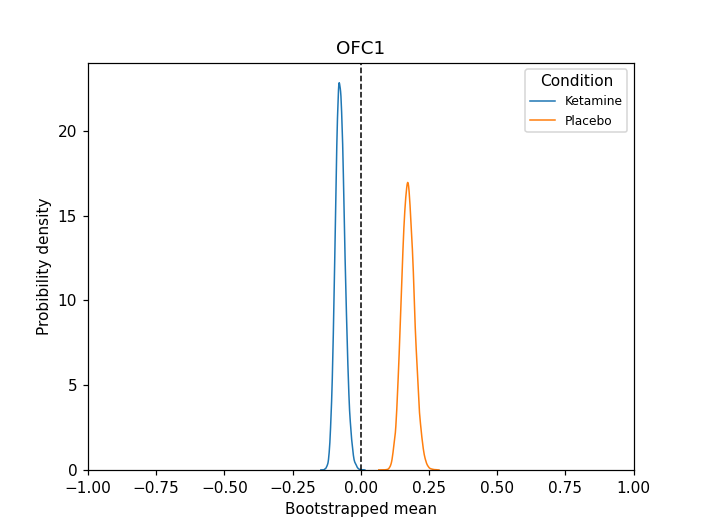

In [30]:
plot_ket_placebo(ofc, 'OFC1')

In [31]:
ofc

,Ketamine,Placebo,Ketamine-Placebo
0,-0.087134,0.207487,-0.279339
1,-0.088283,0.178719,-0.270967
2,-0.014062,0.197559,-0.268790
3,-0.055289,0.189592,-0.305845
4,-0.082014,0.187029,-0.244090
...,...,...,...
49995,-0.080114,0.201052,-0.255125
49996,-0.080911,0.161486,-0.251045
49997,-0.072936,0.143937,-0.253240
49998,-0.074131,0.186140,-0.241269


In [32]:
bsr

array([-0.27933922, -0.27096696, -0.26879014, ..., -0.25324002,
       -0.24126896, -0.23369609])

In [33]:
calulcate_p_value_1(bsr_k)

P value:  0.00028


In [34]:
calulcate_p_value_2(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


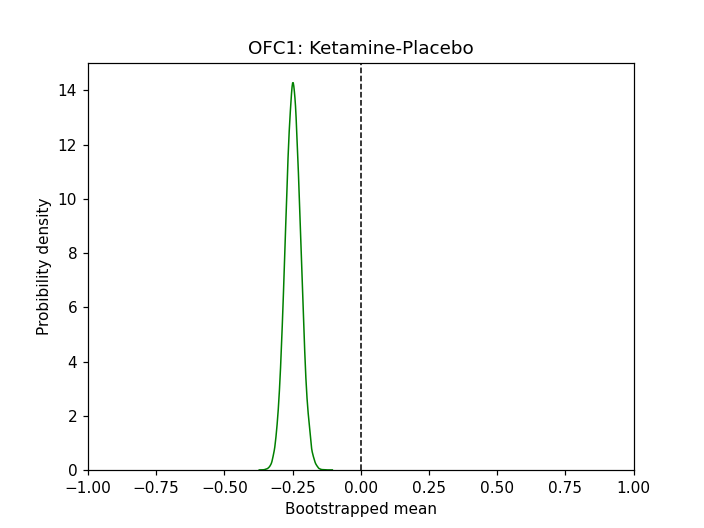

In [35]:
plot_interaction(ofc, 'OFC1')

In [36]:
calulcate_p_value_1(bsr)

P value:  0.0


# OFC2

In [37]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC2')

<IPython.core.display.Javascript object>


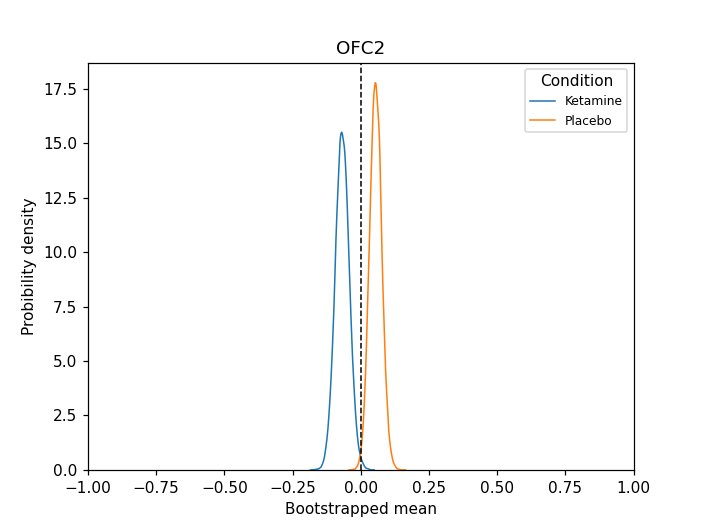

In [38]:
plot_ket_placebo(bsr_com, 'OFC2')

In [39]:
calulcate_p_value_1(bsr_k)

P value:  0.01188


In [40]:
calulcate_p_value_2(bsr_p)

P value:  0.01268


<IPython.core.display.Javascript object>


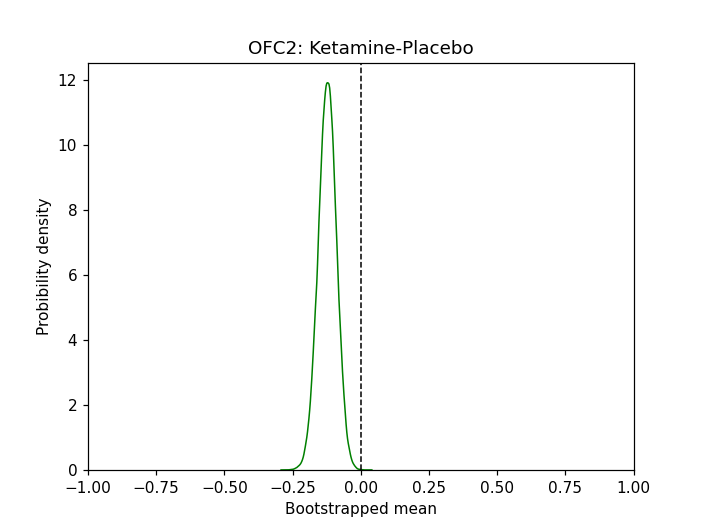

In [41]:
plot_interaction(bsr_com, 'OFC2')

In [42]:
calulcate_p_value_1(bsr)

P value:  0.0002


# OFC3

In [43]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC3')

<IPython.core.display.Javascript object>


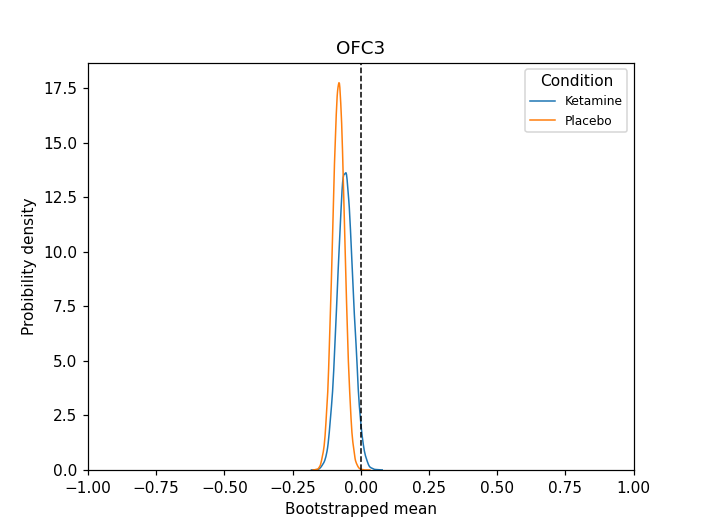

In [44]:
plot_ket_placebo(bsr_com, 'OFC3')

In [45]:
calulcate_p_value_1(bsr_k)

P value:  0.05592


In [46]:
calulcate_p_value_1(bsr_p)

P value:  0.0004


<IPython.core.display.Javascript object>


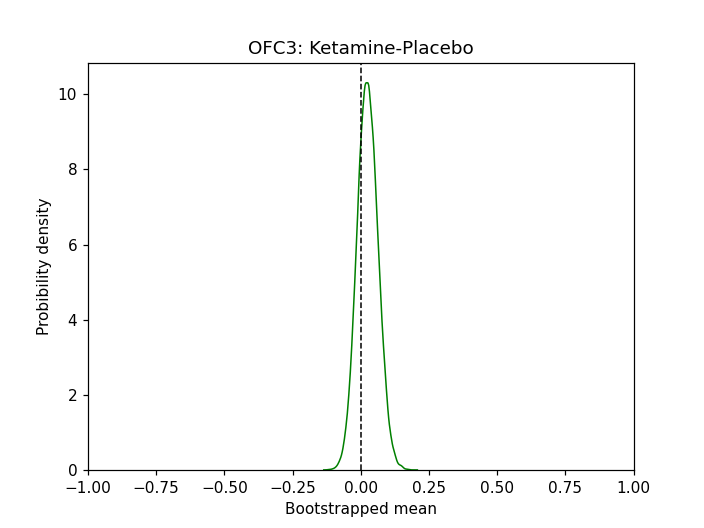

In [47]:
plot_interaction(bsr_com, 'OFC3')

In [49]:
calulcate_p_value_2(bsr)

P value:  0.51828


# OFC4

In [50]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC4')

<IPython.core.display.Javascript object>


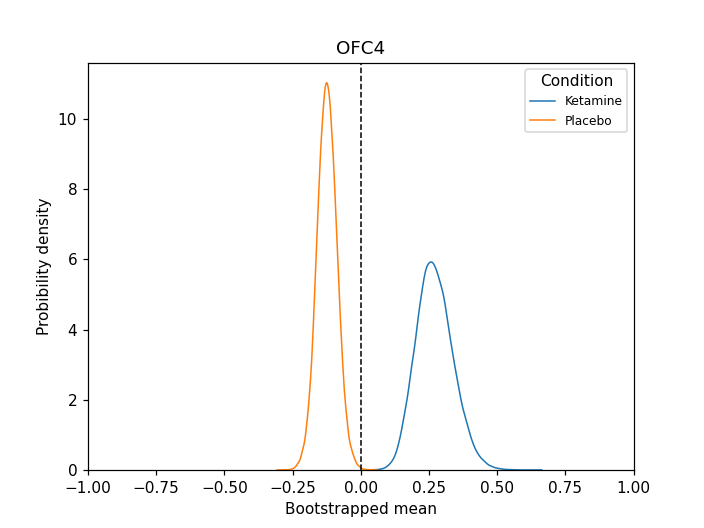

In [51]:
plot_ket_placebo(bsr_com, 'OFC4')

In [53]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [54]:
calulcate_p_value_1(bsr_p)

P value:  0.00144


<IPython.core.display.Javascript object>


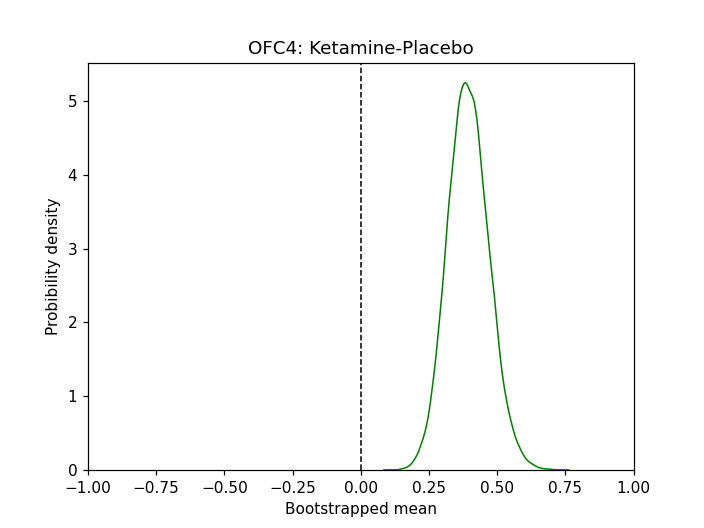

In [55]:
plot_interaction(bsr_com, 'OFC4')

In [57]:
calulcate_p_value_2(bsr)

P value:  0.0


# OFC5

In [58]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC5')

<IPython.core.display.Javascript object>


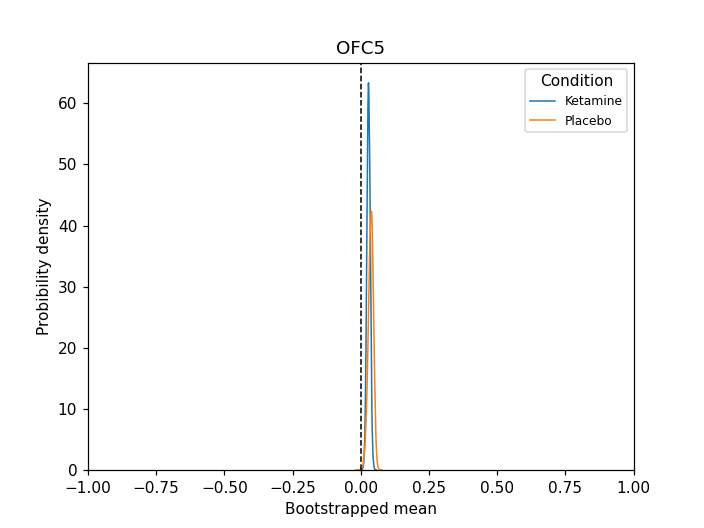

In [59]:
plot_ket_placebo(bsr_com, 'OFC5')

In [61]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [62]:
calulcate_p_value_1(bsr_p)

P value:  1.99912


<IPython.core.display.Javascript object>


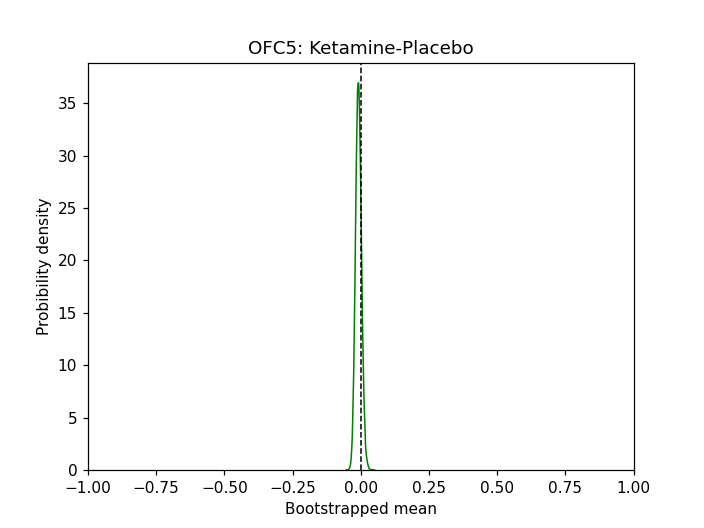

In [63]:
plot_interaction(bsr_com, 'OFC5')

In [64]:
calulcate_p_value_1(bsr)

P value:  0.43396


# OFC6

In [65]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC6')

<IPython.core.display.Javascript object>


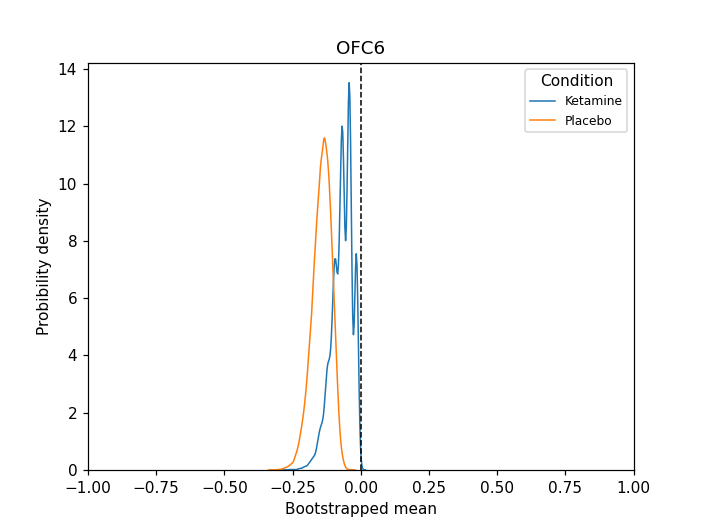

In [66]:
plot_ket_placebo(bsr_com, 'OFC6')

In [67]:
calulcate_p_value_1(bsr_k)

P value:  0.0006


In [68]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


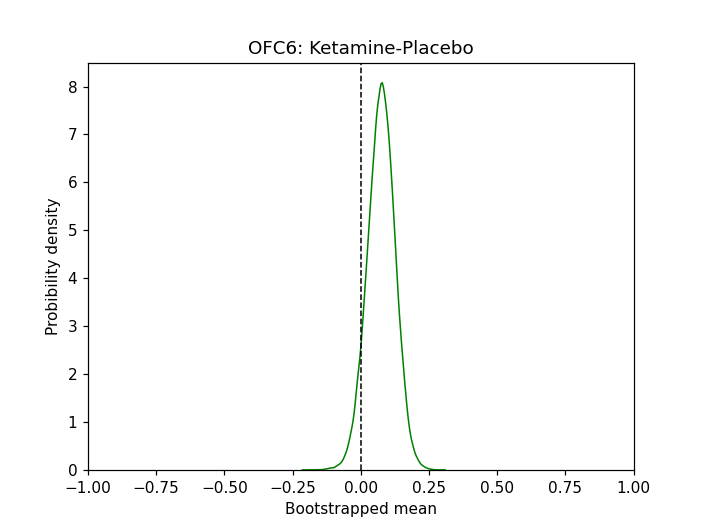

In [69]:
plot_interaction(bsr_com, 'OFC6')

In [71]:
calulcate_p_value_2(bsr)

P value:  0.14832


# OFC7

In [72]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC7')

<IPython.core.display.Javascript object>


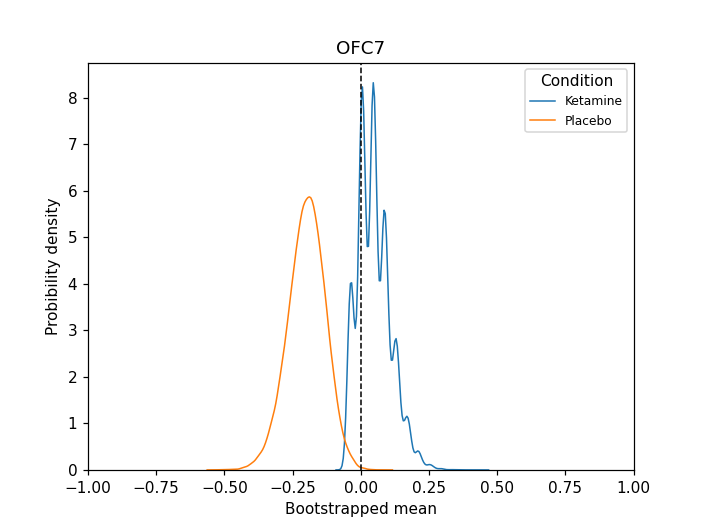

In [73]:
plot_ket_placebo(bsr_com, 'OFC7')

In [75]:
calulcate_p_value_2(bsr_k)

P value:  0.41628


In [76]:
calulcate_p_value_1(bsr_p)

P value:  0.00228


<IPython.core.display.Javascript object>


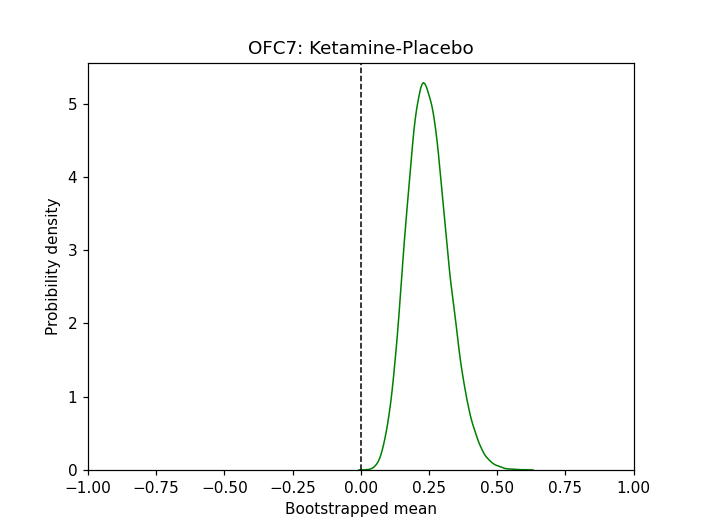

In [77]:
plot_interaction(bsr_com, 'OFC7')

In [79]:
calulcate_p_value_2(bsr)

P value:  0.0


# FP2

In [80]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('FP2')

<IPython.core.display.Javascript object>


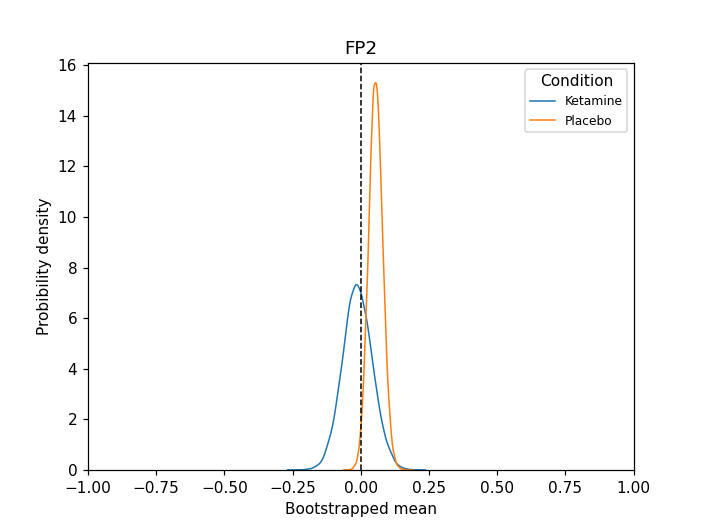

In [81]:
plot_ket_placebo(bsr_com, 'FP2')

In [82]:
calulcate_p_value_1(bsr_k)

P value:  0.81908


In [83]:
calulcate_p_value_1(bsr_p)

P value:  1.96888


<IPython.core.display.Javascript object>


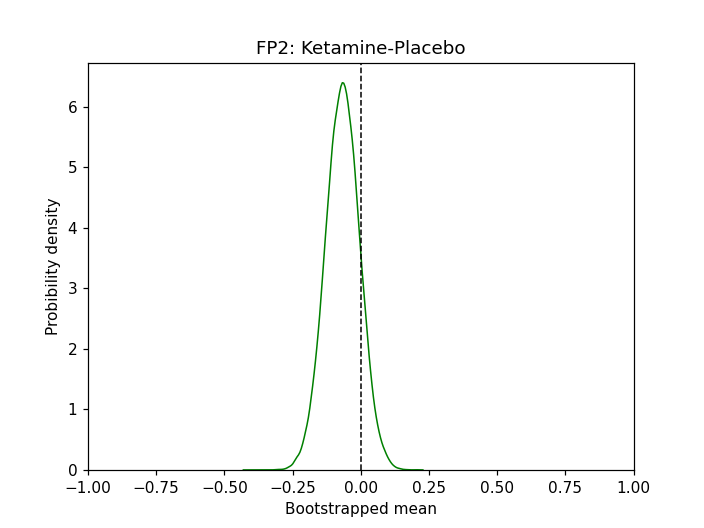

In [84]:
plot_interaction(bsr_com, 'FP2')

In [85]:
calulcate_p_value_1(bsr)

P value:  0.28036


# 25

In [86]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('25')

<IPython.core.display.Javascript object>


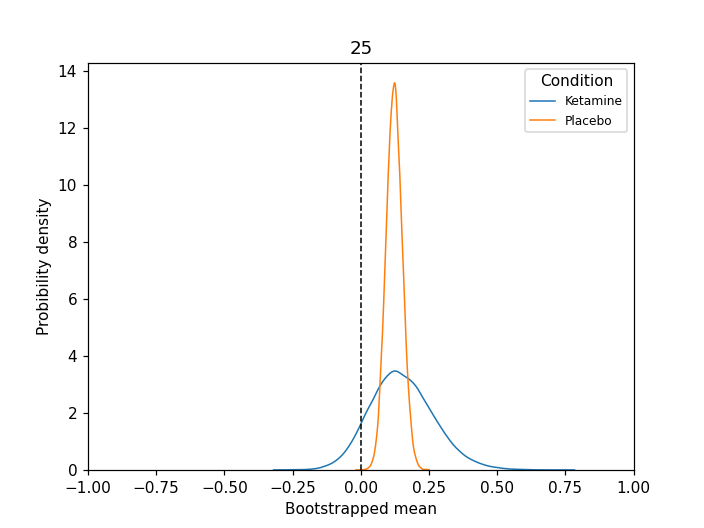

In [87]:
plot_ket_placebo(bsr_com, '25')

In [88]:
calulcate_p_value_2(bsr_k)

P value:  0.1784


In [89]:
calulcate_p_value_2(bsr_p)

P value:  8e-05


<IPython.core.display.Javascript object>


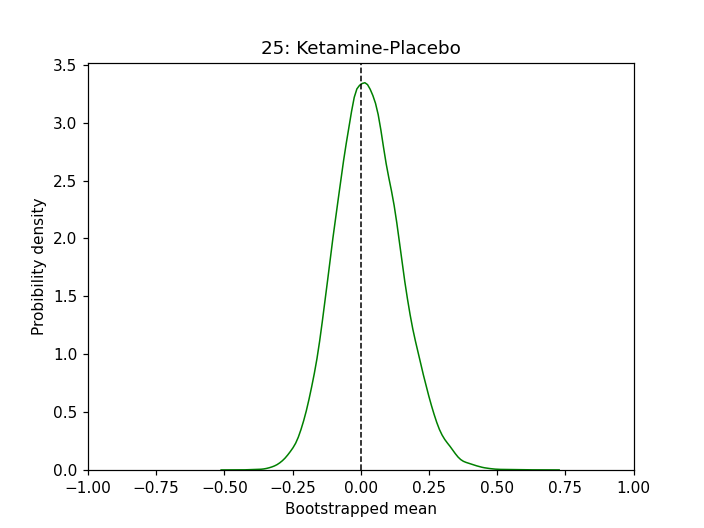

In [90]:
plot_interaction(bsr_com, '25')

In [91]:
calulcate_p_value_2(bsr)

P value:  0.84712


# 33

In [92]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('33')

<IPython.core.display.Javascript object>


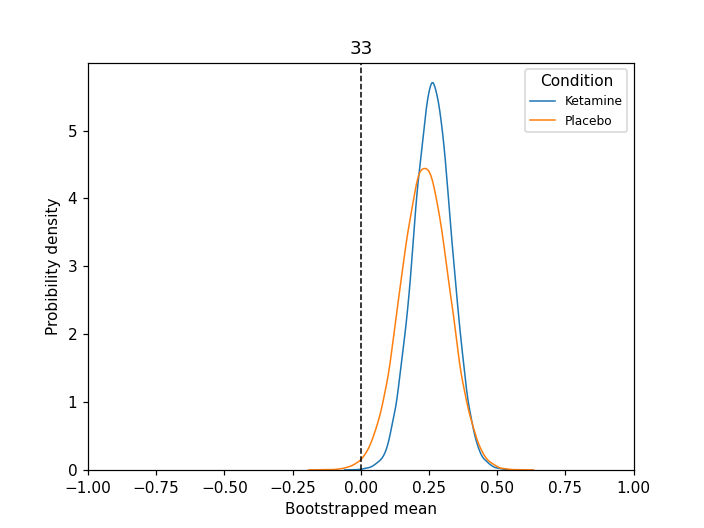

In [93]:
plot_ket_placebo(bsr_com, '33')

In [94]:
calulcate_p_value_2(bsr_k)

P value:  0.00032


In [95]:
calulcate_p_value_2(bsr_p)

P value:  0.01036


<IPython.core.display.Javascript object>


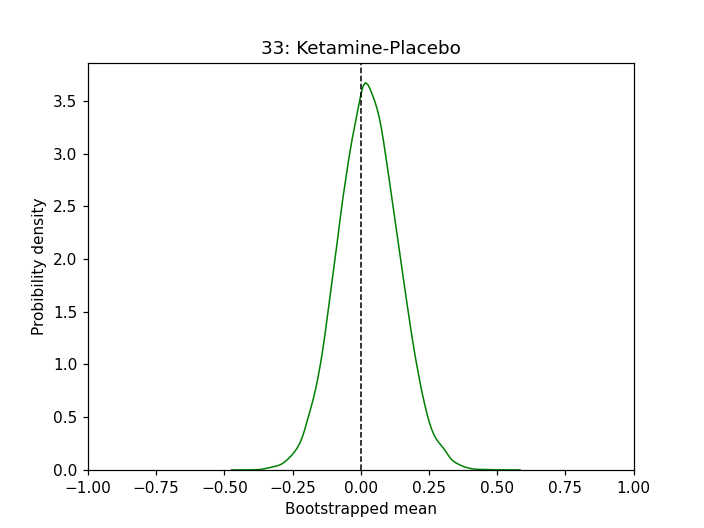

In [96]:
plot_interaction(bsr_com, '33')

In [84]:
calulcate_p_value_2(bsr)

P value:  0.68292


# p24c

In [97]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('p24c')

<IPython.core.display.Javascript object>


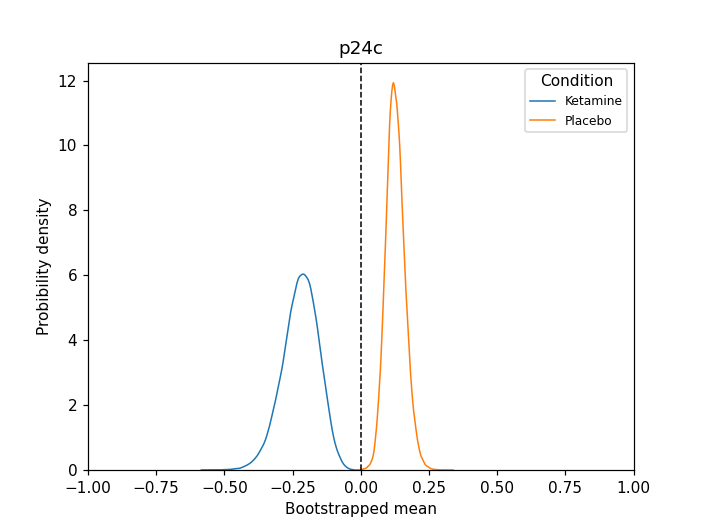

In [98]:
plot_ket_placebo(bsr_com, 'p24c')

In [99]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [100]:
calulcate_p_value_2(bsr_p)

P value:  8e-05


<IPython.core.display.Javascript object>


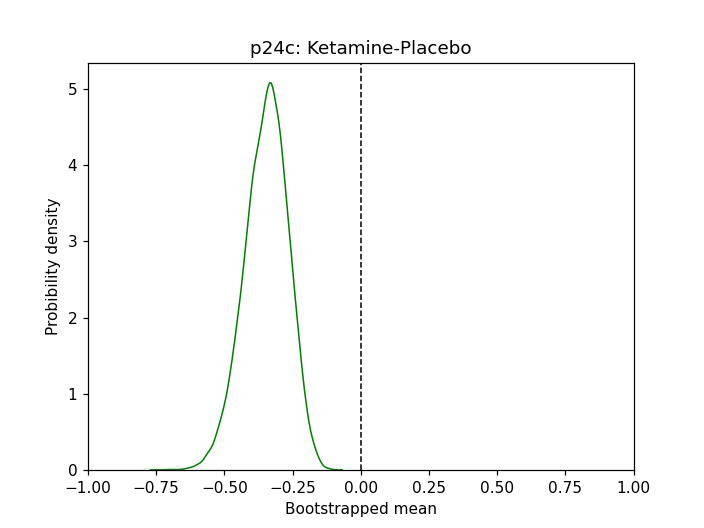

In [101]:
plot_interaction(bsr_com, 'p24c')

In [102]:
calulcate_p_value_1(bsr)

P value:  0.0


# p24ab

In [103]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('p24ab')

<IPython.core.display.Javascript object>


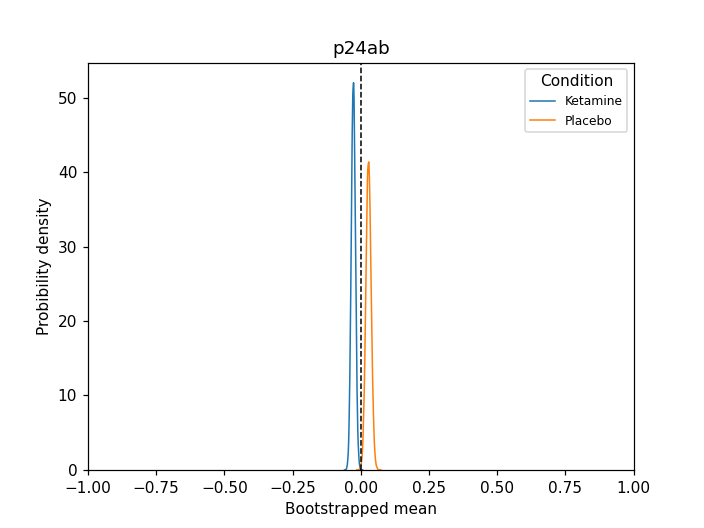

In [104]:
plot_ket_placebo(bsr_com, 'p24ab')

<IPython.core.display.Javascript object>


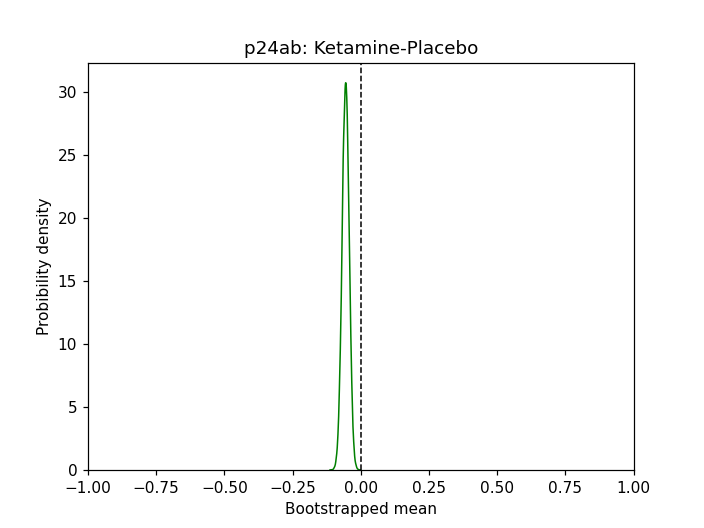

In [105]:
plot_interaction(bsr_com, 'p24ab')

# s32

In [106]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('s32')

<IPython.core.display.Javascript object>


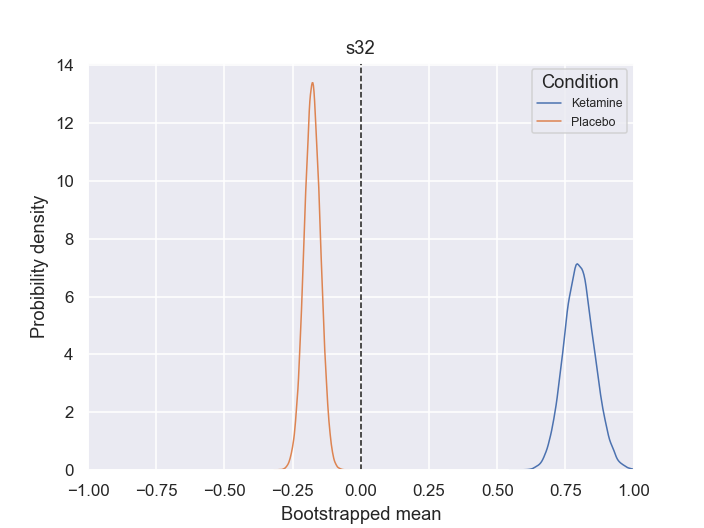

In [9]:
# s32 loaded from saved bootstrap
plot_ket_placebo(s32, 's32')

In [109]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [110]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


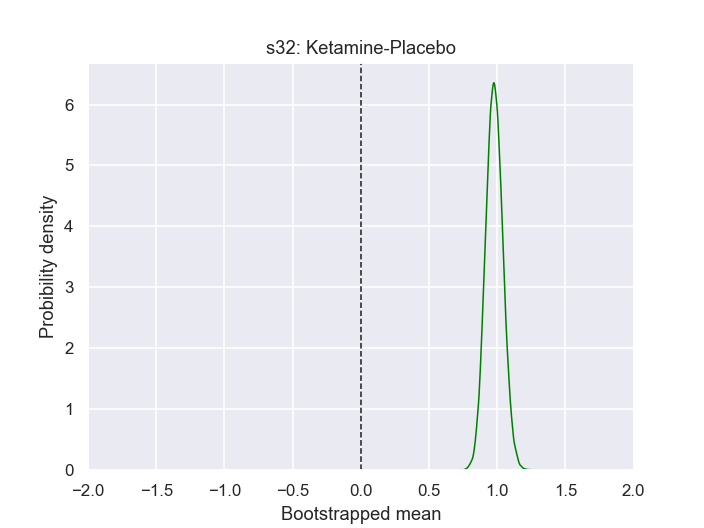

In [14]:
plot_interaction(s32, 's32')

In [113]:
calulcate_p_value_2(bsr)

P value:  0.0


# s24

In [114]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('s24')

<IPython.core.display.Javascript object>


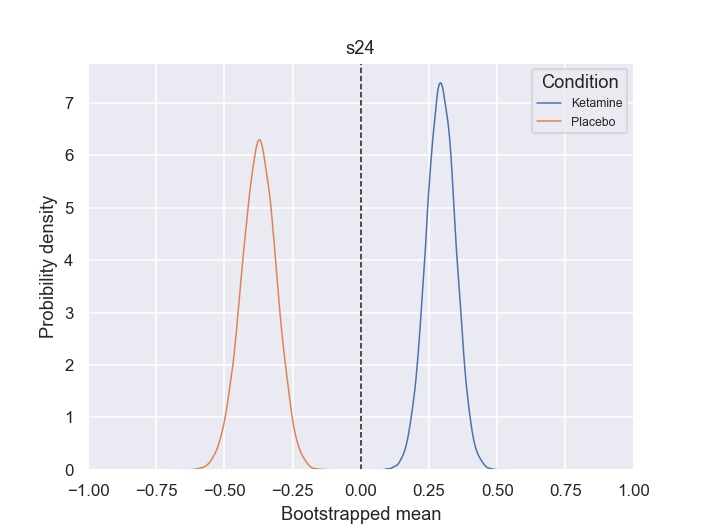

In [11]:
plot_ket_placebo(s24, 's24')

In [116]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [117]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


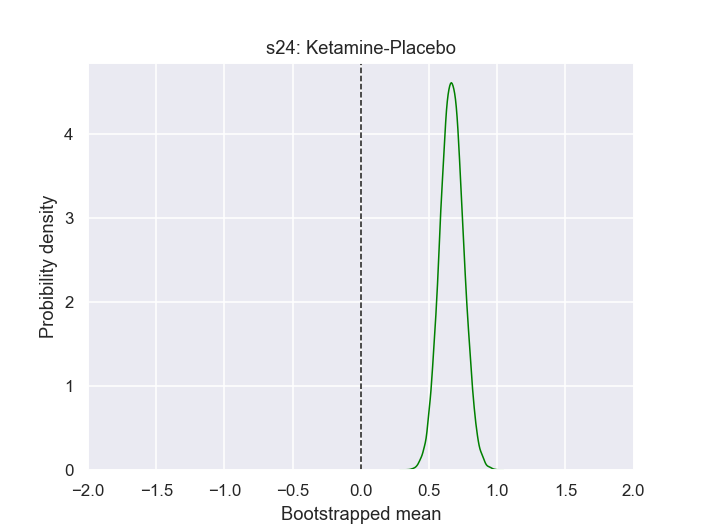

In [15]:
plot_interaction(s24, 's24')

In [119]:
calulcate_p_value_2(bsr)

P value:  0.0


# p32

In [120]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('p32')

<IPython.core.display.Javascript object>


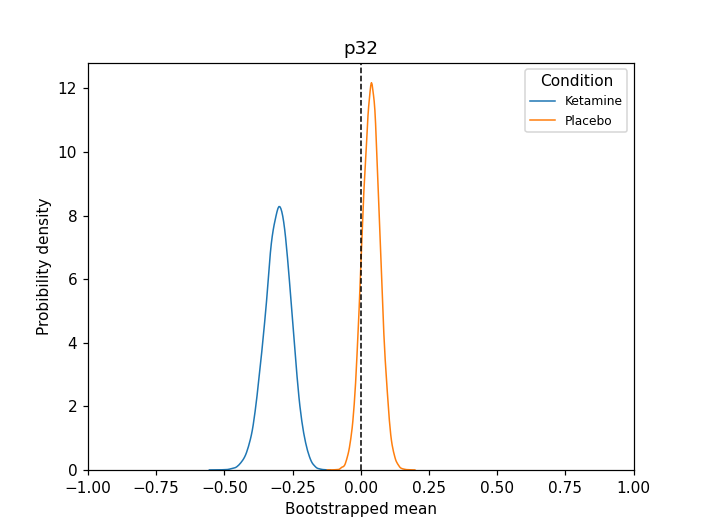

In [121]:
plot_ket_placebo(bsr_com, 'p32')

In [122]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [123]:
calulcate_p_value_1(bsr_p)

P value:  1.74832


<IPython.core.display.Javascript object>


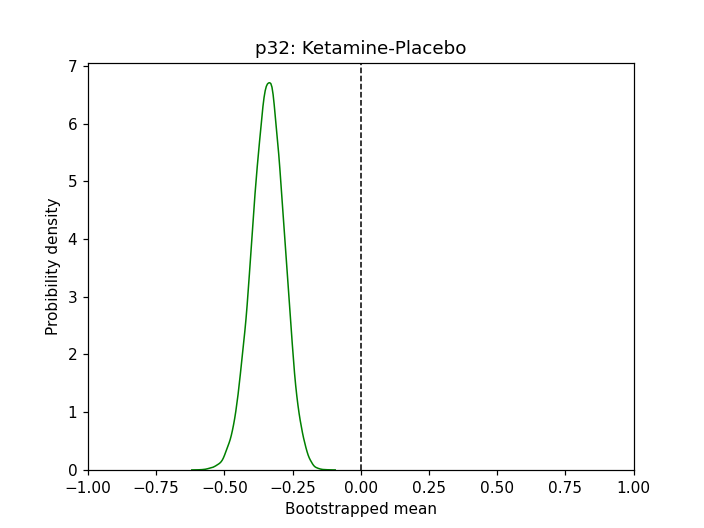

In [124]:
plot_interaction(bsr_com, 'p32')

In [125]:
calulcate_p_value_1(bsr)

P value:  0.0


# Caudate

In [126]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('Caudate')

<IPython.core.display.Javascript object>


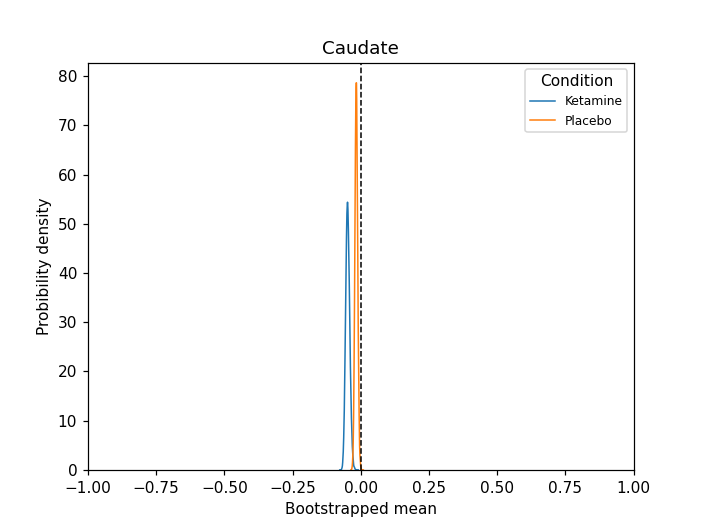

In [127]:
plot_ket_placebo(bsr_com, 'Caudate')

<IPython.core.display.Javascript object>


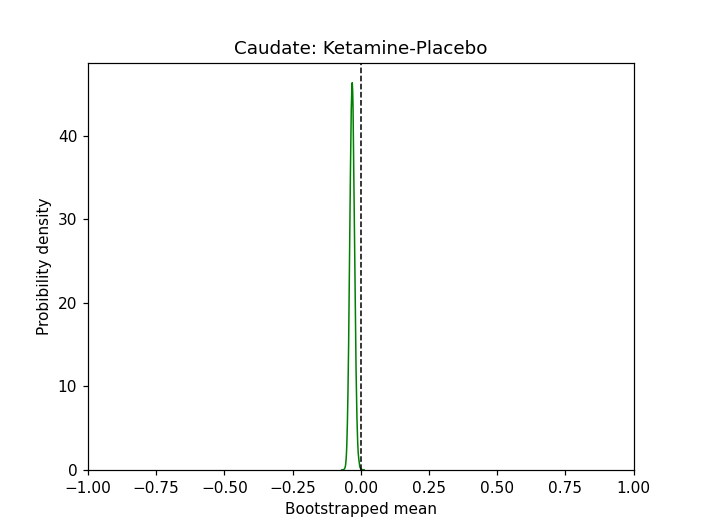

In [128]:
plot_interaction(bsr_com, 'Caudate')

# Putamen

In [129]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('Putamen')

<IPython.core.display.Javascript object>


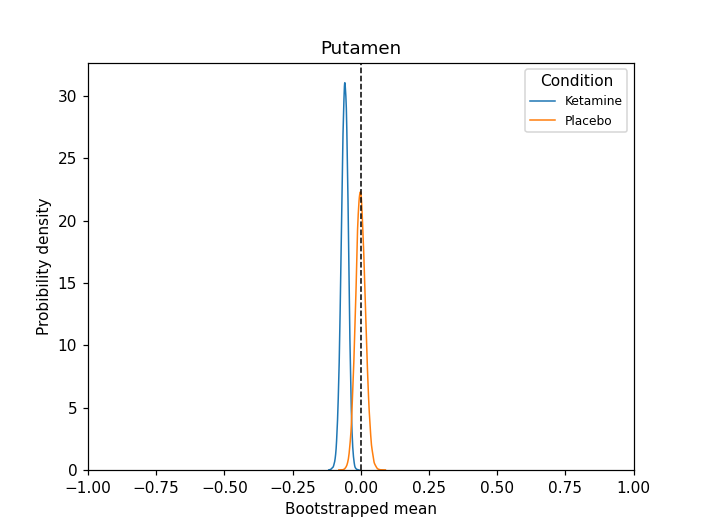

In [130]:
plot_ket_placebo(bsr_com, 'Putamen')

In [131]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [132]:
calulcate_p_value_1(bsr_p)

P value:  0.95056


<IPython.core.display.Javascript object>


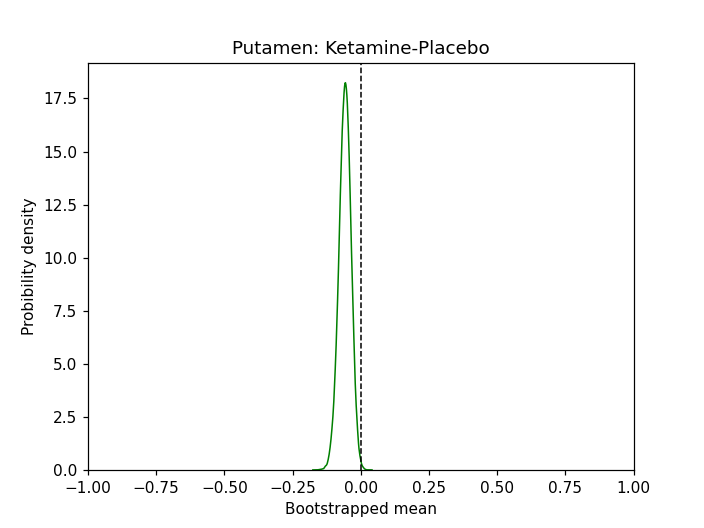

In [133]:
plot_interaction(bsr_com, 'Putamen')

In [134]:
calulcate_p_value_1(bsr)

P value:  0.00528


# NAcc

In [135]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('NAcc')

<IPython.core.display.Javascript object>


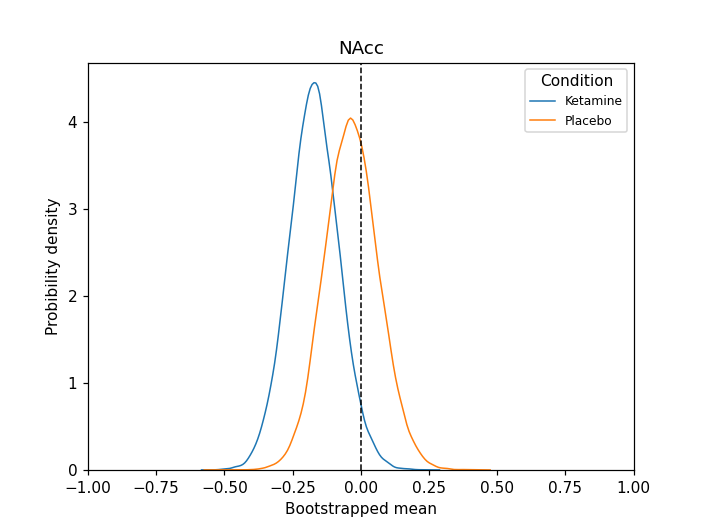

In [136]:
plot_ket_placebo(bsr_com, 'NAcc')

<IPython.core.display.Javascript object>


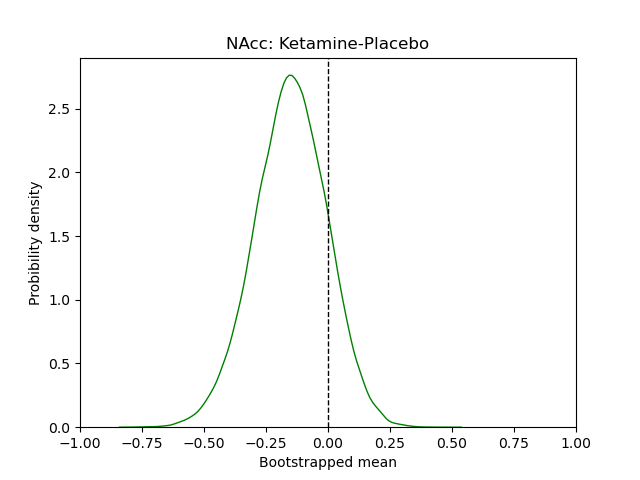

In [125]:
plot_interaction(bsr_com, 'NAcc')